In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import keras.backend as K
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, Concatenate, Add
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm,trange
from sklearn.utils import shuffle
import time as time
from keras.utils import plot_model

Using TensorFlow backend.


Generating graph...
Graph generated.
Graph statistics: 600 nodes, 65090 edges
Number of hypergraph random walks: 200000
Generating graph embeddings...


W0729 17:44:14.415879 4471715264 base_any2vec.py:1230] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


Number of graph random walks: 15000
Graph embeddings generated.


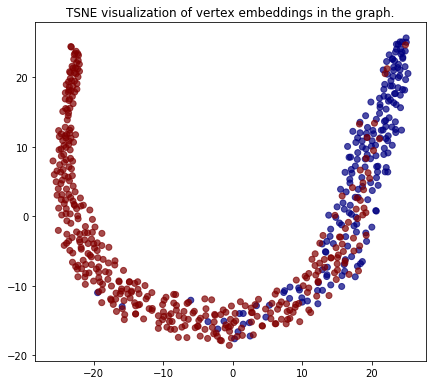

Generating hyperedge embeddings...
Hypergraph embeddings generated.


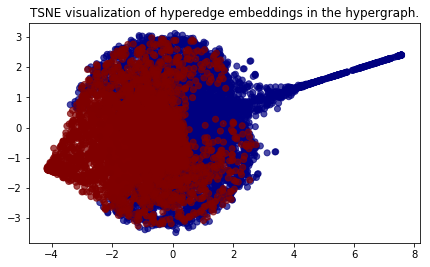

Generating hypergraph node embeddings...
Hypergraph embeddings generated.


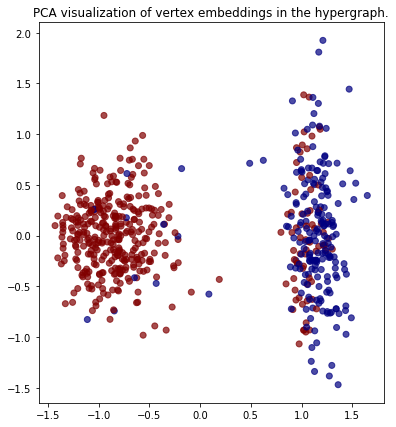

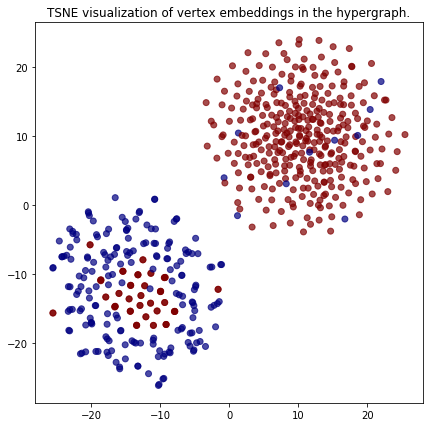

In [2]:
import embed

In [2]:
# num_train_examples = embed.num_positive+embed.num_negative
# embedding_dimension = embed.embedding_dimension
# max_train_length = embed.max_h+6

num_train_examples = 10000
embedding_dimension = 128
max_train_length = 21

num_test_examples = 50
min_test_length=4
max_test_length=4
step_test_length=4

In [4]:
# def getTrainingData():
#     X = np.zeros((num_train_examples,max_train_length*embedding_dimension))
#     Y = np.zeros((num_train_examples))
#     for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
#         n = max_train_length # np.random.randint(1,max_train_length)
#         for j in range(1,n+1):
#             for k in range(embedding_dimension):
#                 X[i,-j+(n*k)] = np.random.randint(1,10)
#         Y[i] = np.random.randint(0,1)
#     return X, Y

# X, Y = getTrainingData()


In [32]:
def getTrainingData(obj):
    num_positive = embed.num_positive
    num_negative = embed.num_negative
    lists = []
    if obj=="graph":
        lists = embed.getGraphNodeEmbeddingHyperedges()
    elif obj=="hypergraph":
        lists = embed.getHypergraphNodeEmbeddingHyperedges()
    elif obj=="hyperedge":
        lists = embed.getHyperedgeEmbeddingHyperedges()
    X_unshuffled = []
    for hlist in lists:
        hlist = np.asarray(hlist)
        x = np.zeros((embedding_dimension*max_train_length,))
        i = 0
        for embedding in hlist:
            x[i*embedding.shape[0]:(i+1)*embedding.shape[0]] = embedding
            i+=1
        X_unshuffled.append(x)
    labels = np.zeros(num_negative+num_positive)
    labels[num_negative:]=np.ones(num_positive)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X = np.asarray(X_arr)
    Y = np.asarray(Y_arr)
    return X, Y

X, Y = getTrainingData("hyperedge")


In [33]:
# np.save('X_hyperedge.npy', X)
# np.save('Y_hyperedge.npy', Y)

In [3]:
X = np.load('X_hyperedge.npy')
Y = np.load('Y_hyperedge.npy')

W0730 17:53:03.430510 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 17:53:03.444270 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 17:53:03.524539 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 17:53:04.009792 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use

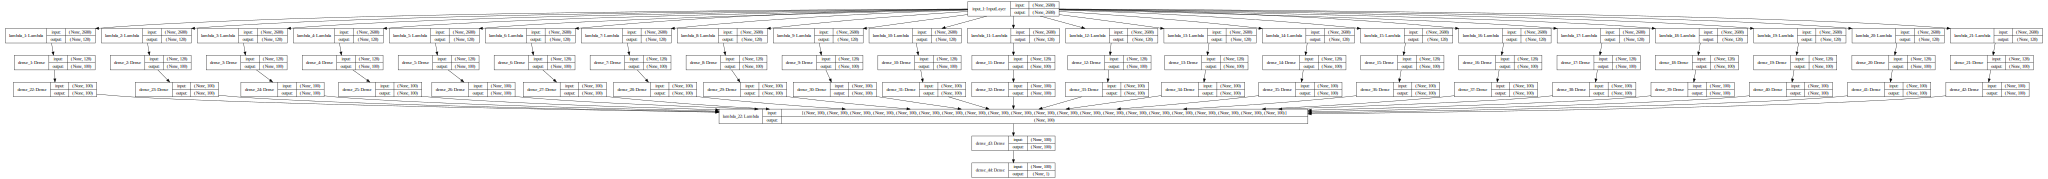

In [4]:
input_tensor = Input((embedding_dimension*max_train_length,))

layer_1 = {}
layer_2 = {}
layer_3 = {}
layer_2_depth = 100
layer_3_depth = 100
dense_rho_depth = 100
sum_list = []

### Split into embeddings
for i in range(max_train_length):
    key = "layer_1_"+str(i)
    exec("value = Lambda(lambda x: x[:,"+str(embedding_dimension*i)+":"+str(embedding_dimension*(i+1))+"], output_shape=(("+str(embedding_dimension)+",)))(input_tensor)") # necessary, as lambdas will take the variable names (and not values) with them
    layer_1[key] = value

### Dense layer 1 for embeddings
for i in range(max_train_length):
    key = "layer_2_"+str(i)
    value = Dense(layer_2_depth, activation='relu')(layer_1["layer_1_"+str(i)])
    layer_2[key] = value

### Dense layer 2 for embeddings
for i in range(max_train_length):
    key = "layer_3_"+str(i)
    value = Dense(layer_3_depth, activation='relu')(layer_2["layer_2_"+str(i)])
    layer_3[key] = value

### Sum layer for embeddings
for i in range(max_train_length):
    sum_list.append(layer_3["layer_3_"+str(i)])

Adder = Lambda(lambda x: K.sum(x, axis=0))

summed = Adder(sum_list)
dense_rho = Dense(dense_rho_depth, activation='sigmoid')(summed)
output_tensor = Dense(1, activation='sigmoid')(dense_rho)

deepset_model = Model(inputs=input_tensor,outputs=output_tensor)

adam = Adam(lr=1e-4, epsilon=1e-3)
deepset_model.compile(optimizer=adam, loss='mae')

plot_model(deepset_model, to_file='deepset_model.png')
SVG(model_to_dot(deepset_model, show_shapes=True).create(prog='dot', format='svg'))

W0730 17:53:08.303272 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0730 17:53:09.276646 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 9000 samples, validate on 1000 samples


W0730 17:53:11.323144 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0730 17:53:11.324056 4356310464 deprecation_wrapper.py:119] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
9000/9000 [==============================] - 4s 481us/step - loss: 0.3720 - val_loss: 0.2610
Epoch 2/10
9000/9000 [==============================] - 3s 351us/step - loss: 0.1932 - val_loss: 0.1586
Epoch 3/10
9000/9000 [==============================] - 3s 364us/step - loss: 0.1265 - val_loss: 0.1138
Epoch 4/10
9000/9000 [==============================] - 3s 346us/step - loss: 0.0964 - val_loss: 0.0872
Epoch 5/10
9000/9000 [==============================] - 3s 348us/step - loss: 0.0779 - val_loss: 0.0695
Epoch 6/10
9000/9000 [==============================] - 3s 358us/step - loss: 0.0655 - val_loss: 0.0579
Epoch 7/10
9000/9000 [==============================] - 3s 352us/step - loss: 0.0564 - val_loss: 0.0484
Epoch 8/10
9000/9000 [==============================] - 3s 370us/step - loss: 0.0488 - val_loss: 0.0419
Epoch 9/10
9000/9000 [==============================] - 3s 345us/step - loss: 0.0436 - val_loss: 0.0362
Epoch 10/10
9000/9000 [==============================] - 3s 349u

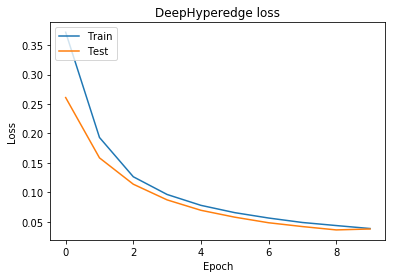

In [5]:
checkpointer = ModelCheckpoint(filepath='data/deepset_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./deepHElogs', histogram_freq=0, batch_size=max_train_length, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = deepset_model.fit(X, Y, epochs=10, batch_size=max_train_length,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

deepset_model = load_model('data/deepset_weights.hdf5')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DeepHyperedge loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [6]:
def get_lstm_model():
    input_tensor = Input(shape=(max_train_length,embedding_dimension))
    x = LSTM(100)(input_tensor)
    dense_rho = Dense(100, activation='sigmoid')(x)
    output_tensor = Dense(1, activation='sigmoid')(dense_rho)
    model = Model(input_tensor, output_tensor)
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='mae')
    plot_model(model, to_file='lstm_model.png')
    return model

In [7]:
def get_gru_model():
    input_tensor = Input(shape=(max_train_length,embedding_dimension))
    x = GRU(100)(input_tensor)
    dense_rho = Dense(100, activation='sigmoid')(x)
    output_tensor = Dense(1, activation='sigmoid')(dense_rho)
    model = Model(input_tensor, output_tensor)
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='mae')
    plot_model(model, to_file='gru_model.png')
    return model

(10000, 21, 128)


W0730 17:54:07.886896 4356310464 deprecation.py:323] From /Users/joshua.f.payneibm.com/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 9s 976us/step - loss: 0.4100 - val_loss: 0.4056
Epoch 2/10
9000/9000 [==============================] - 8s 876us/step - loss: 0.3998 - val_loss: 0.4053
Epoch 3/10
9000/9000 [==============================] - 8s 908us/step - loss: 0.3997 - val_loss: 0.4052
Epoch 4/10
9000/9000 [==============================] - 8s 889us/step - loss: 0.3996 - val_loss: 0.4051
Epoch 5/10
9000/9000 [==============================] - 8s 909us/step - loss: 0.3996 - val_loss: 0.4051
Epoch 6/10
9000/9000 [==============================] - 8s 903us/step - loss: 0.3996 - val_loss: 0.4050
Epoch 7/10
9000/9000 [==============================] - 8s 905us/step - loss: 0.1769 - val_loss: 0.0934
Epoch 8/10
9000/9000 [==============================] - 8s 911us/step - loss: 0.0572 - val_loss: 0.0537
Epoch 9/10
9000/9000 [==============================] - 8s 921us/step - loss: 0.0502 - val_loss: 0.0839
Epoch 10/10
9000

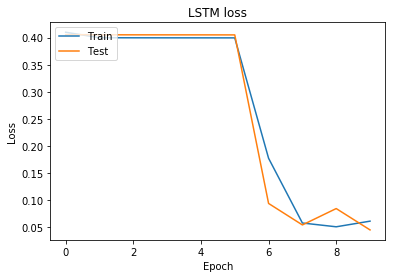

In [8]:
def runLSTM():
    sequential_X = []
    for i in X:
        twoDim = np.reshape(i,(max_train_length,embedding_dimension)).tolist()
        sequential_X.append(twoDim)
    print(np.array(sequential_X).shape)
    model = get_lstm_model()
    checkpointer = ModelCheckpoint(filepath='data/lstm_weights.hdf5', verbose=0, save_best_only=True)
    tbCallBack = TensorBoard(log_dir='./LSTMlogs', histogram_freq=0, batch_size=max_train_length, write_graph=True, write_grads=True, write_images=True, update_freq='batch')
    history = model.fit(np.array(sequential_X), np.array(Y), epochs=10, batch_size=max_train_length,
            shuffle=True, validation_split=0.1,
            callbacks=[checkpointer,tbCallBack])

    model = load_model('data/lstm_weights.hdf5')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

runLSTM()

In [ ]:
# def runDeepSet(model):
    
#     adam = Adam(lr=1e-4, epsilon=1e-3)
#     model.compile(optimizer=adam, loss='mae')

#     plot_model(model, to_file='deepset_model.png')
#     checkpointer = ModelCheckpoint(filepath='data/deepset_weights.hdf5', verbose=0, save_best_only=True)

#     model.fit(X, Y, epochs=10, batch_size=max_train_length,
#             shuffle=True, validation_split=0.1,
#             callbacks=[checkpointer])

#     model = load_model('data/deepset_weights.hdf5')
#     SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# runDeepSet(model)


(10000, 21, 128)
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 8s 854us/step - loss: 0.4254 - val_loss: 0.4062
Epoch 2/10
9000/9000 [==============================] - 8s 851us/step - loss: 0.4004 - val_loss: 0.4056
Epoch 3/10
9000/9000 [==============================] - 7s 815us/step - loss: 0.4000 - val_loss: 0.4054
Epoch 4/10
9000/9000 [==============================] - 7s 811us/step - loss: 0.3999 - val_loss: 0.4053
Epoch 5/10
9000/9000 [==============================] - 7s 796us/step - loss: 0.3998 - val_loss: 0.4053
Epoch 6/10
9000/9000 [==============================] - 7s 754us/step - loss: 0.3997 - val_loss: 0.4052
Epoch 7/10
9000/9000 [==============================] - 7s 768us/step - loss: 0.3997 - val_loss: 0.4052
Epoch 8/10
9000/9000 [==============================] - 7s 772us/step - loss: 0.3996 - val_loss: 0.4052
Epoch 9/10
9000/9000 [==============================] - 7s 768us/step - loss: 0.3996 - val_loss: 0.4051

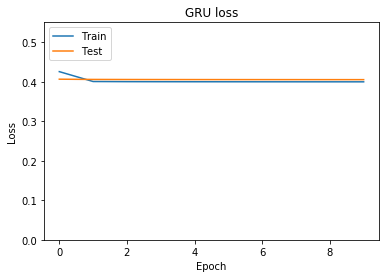

In [12]:
def runGRU():
    sequential_X = []
    for i in X:
        twoDim = np.reshape(i,(max_train_length,embedding_dimension)).tolist()
        sequential_X.append(twoDim)
    print(np.array(sequential_X).shape)
    model = get_gru_model()
    checkpointer = ModelCheckpoint(filepath='data/gru_weights.hdf5', verbose=0, save_best_only=True)
    tbCallBack = TensorBoard(log_dir='./GRUlogs', histogram_freq=0, batch_size=max_train_length, write_graph=True, write_grads=True, write_images=True, update_freq='batch')
    history = model.fit(np.array(sequential_X), np.array(Y), epochs=10, batch_size=max_train_length,
            shuffle=True, validation_split=0.1,
            callbacks=[checkpointer,tbCallBack])

    model = load_model('data/gru_weights.hdf5')
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('GRU loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0,0.55])
    plt.show()
    
    
runGRU()
    

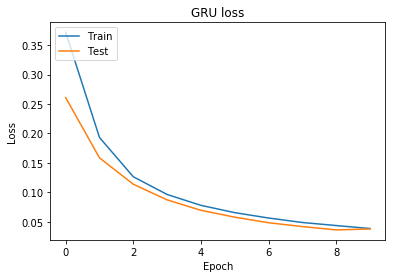

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GRU loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()